# Week 6: Homework 2 

----------------------------------------------------
Machine Learning                      

Year 2019/2020

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es* 

----------------------------------------------------

#1. Introduction to ensembles

The goal of ensemble learning is to combine a set of base learners to build an improved prediction model. The key idea  behind ensembles lies in exploiting the diversity among the base learners; the way of generating this diversity let us classify these methods into two main types:

* **Bagging**: the diversity  among classifiers (called learners) is generated using different partitions of the training data. Then we train and combine the output.
* **Boosting**: it sequentially train a set of weak classifiers using modified versions of the data. Here we get diversity by modifying the training data.

We have already seen a kind of these methods: *Random Forests (RF)*. Remember that RF train a set of trees, each tree use a different subset of samples and features, and later combine their outputs. So, we can say that RF is a Bagging method. 


# 2. Bagging: Boostrap Aggregating

A bagging ensemble combines a set of classiffiers where each base learner is trained with a bagged subset of the training samples. This bagging subsampling consist in randomly, and with replacement,  choosing multiple random samples from the original training data. 

Once the set of base learners is trained, the final ensemble output is obtained by averaging all learner's outputs. In the classification case, usually a majority vote is applied.

You can also train each model in paralel before combining the output.

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bagging.png" width="48%" > 


(*) Figure from https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de


**References**

L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.




# 3. Boosting: Real Adaboost

Boosting methods train a sequence of weak classifiers with weighted or emphasized versions of the training data. Each one of these classifiers is weak since its error rate can be only slightly better than random guessing. Finally, to obtain the final ensemble output, the predictions from all of them are then combined through a weighted combination of all learners' outputs.


The most popular boosting algorithm is called **AdaBoost** (Adaptive Boosting). This boosting method trains this sequence of weak classifiers in such way that each new classifier pay more attention to samples missclassified by the previous learners. Versions of this algorithm are:
* AdaBoost.M1 or  “Discrete AdaBoost” where base learners outputs are discrete estimations of the output class.
* “Real AdaBoost”, in this case, base classifier return a real-valued prediction (e.g., a probability mapped to the interval [−1,1]).

Let's now go deeper in the working principles of the **Real AdaBoost** algorithm.

**References**

* Schapire, R.E. The strength of weak learnability. Machine Learning, 5(2): 1651-1686, 1990.

* Freund, Y. and Schapire, R.E. Experiments with a new boosting algorithm. Proc. of the 13th International Conference on Machine Learning. pp. 148-156, 1996.


## Real Adaboost
Consider we have a binary classification problem given by training dataset $S$ consisting  of $N$ pairs $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)}\in\mathbb{R}^L$ is the $i$-th observation and $y^{(i)}\in\{-1,1\}$  is its associated label.

Real Adaboost (RA) sequentially trains a set of $T$ learners where each learner implements a prediction function $o_t(x) \in [-1,1]$. To learn this prediction function each learner observes the overall training dataset $S$, but an emphasis function $D_t(\mathbf{x})$ is used during its training to make the learner pay more attention to most erroneous samples.
Finally, the ensemble output is obtained as an averaged weighted sum of all learner output:

$$ f_T({\bf x}) = \displaystyle \sum_{t=1}^T \alpha_t o_t({\bf x})$$

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/boosting.jpg" width="30%" > 



* **Emphasis function**:
To force diversity among the base learners, by means of an emphasis function RA applies weights  to each of the training observations. Initially all weights are equal:
$$ D_{1}({\bf x}^{(i)}) = \frac{1}{N}   $$

  so that the first learner is trained in the usual manner. For next iterations,  $t = 2,3,\ldots,T$, the emphasis function updated with the following rule:

$$ D_{t+1}({\bf x}^{(i)}) = \frac{D_{t}({\bf x}^{(i)}) \exp \left( - \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right)}{Z_t}   $$

  where $Z_t$ is a normalization constant making $\sum_{i=1}^N D_{t+1}({\bf x}^{(i)})  = 1$. Note that this update rule increase the emphasis weight for those observations that were misclassified by the previous classifiers, whereas the weights are decreased for those that were  correctly classified. Thus, as new learners are added to the ensemble, most erroneous samples will receive an increased attention.

* **Output weights ($\alpha_t$)**

To obtain the output weights, RA minimizes the exponential loss function:
$${\bf \alpha}^* =\displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - \sum_{t=1}^T \alpha_t o_t({\bf x}^{(i)}) {y}^{(i)} \right) = \displaystyle \underset{{\bf \alpha}}{\operatorname{min}} \sum_{i=1}^N \exp \left( - f_T({\bf x}^{(i)}) {y}^{(i)} \right)$$

which solution can be analytically computed as

$$\alpha_t = \frac{1}{2} \ln \left( \frac{1+\gamma_t}{1-\gamma_t}\right)$$

where $\gamma_t = \sum_{i=1}^N   D_{t}({\bf x}^{(i)}) o_t({\bf x}^{(i)}) {y}^{(i)} $. The effect of these weights is to give higher influence to the more accurate classifiers in the ensemble. 


**Exponential loss**

This cost function, quite similar to the binomial deviance, is un upper bound of the classification error.


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

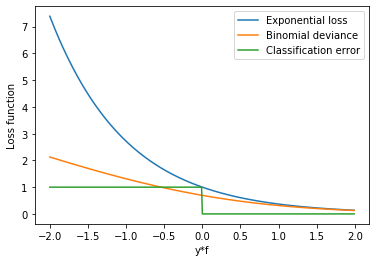

In [2]:
# Plot the exponential loss function (un upper bound of the classfication error)
f = np.arange(-2,2,0.01)
y = 1

l_alpha = np.exp(-y*f)
plt.figure()
plt.plot(y*f,l_alpha, label='Exponential loss')


# Compare with binomial deviance
l_w = np.log(1+ np.exp(f))-y*f
plt.plot(y*f,l_w, label='Binomial deviance')

# Classification error
e_class = np.zeros(f.shape)
e_class[y*f<0] =1
plt.plot(y*f,e_class, label='Classification error')

plt.legend()
plt.xlabel('y*f')
plt.ylabel('Loss function')

plt.show()

# 4. Let's work

The aim of this second HW is to implement and analyse the performance of these enseble methods. To do this, we will work with the Breast Cancer database (described in the next section) and you will have to complete the following exercises.

### Exercise 1. Load and prepare the data

For this lab session, let's work over the  [Breast cancer data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) a binary classification problem aimed to detect breast cancer from a  digitized image of breast mass. For this prupose, the images have been preprocesed and characterized with 30 input features describing the mass.

Complete next cell code, so that you can:
* Load the dataset
* Create training and testing partitions with the 60% and 40% of the original data
* Normalize the data to zero mean and unitary standard deviation 

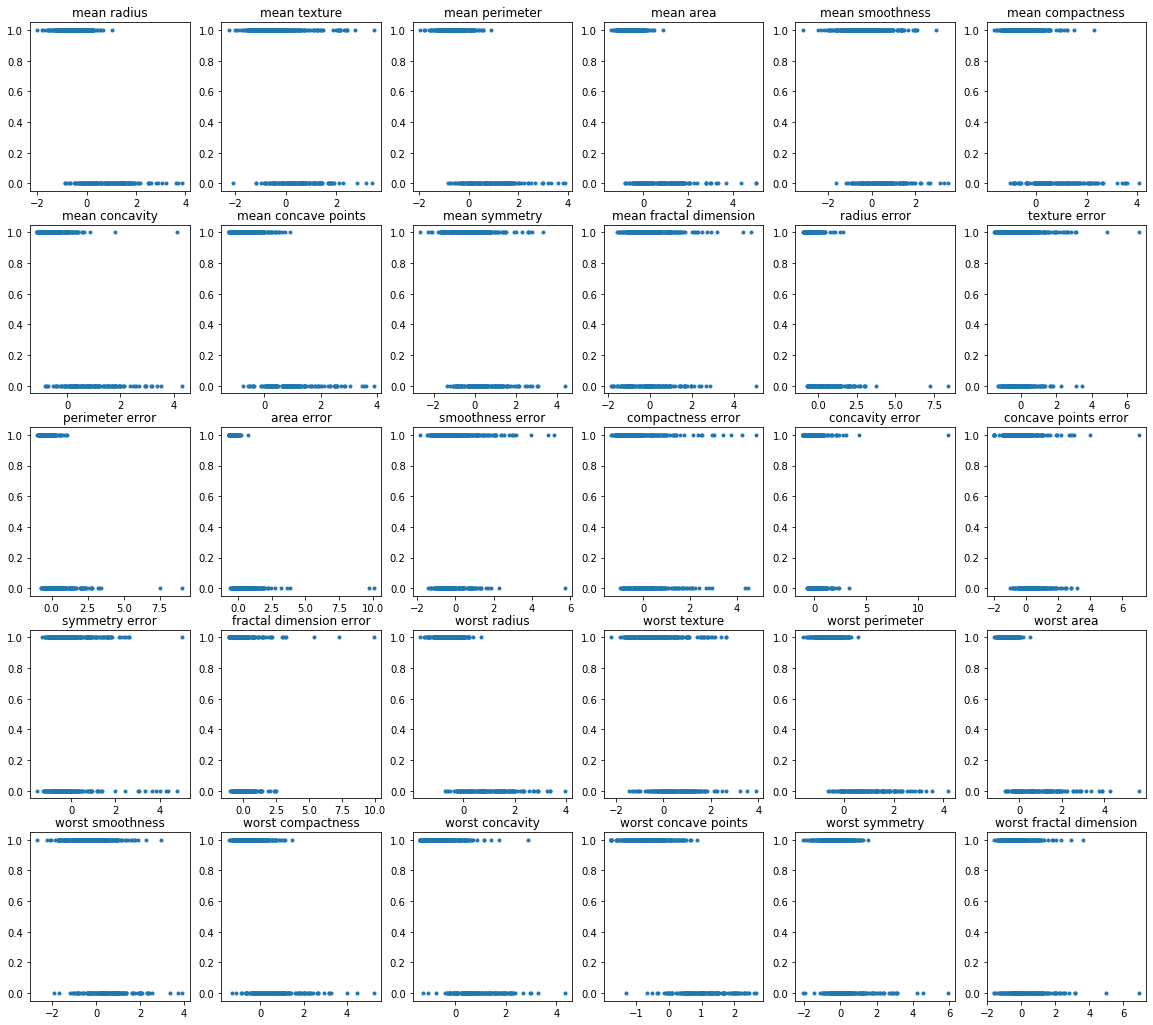

In [3]:
data = load_breast_cancer()

X = data.data
Y = data.target
feature_names = data.feature_names

#Let's apply standard scaling to all the data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)
X_train_norm = transformer.transform(X_train)
X_test_norm =  transformer.transform(X_test)

D = X.shape[1]

plt.figure( figsize=(20,18))
for d in range(D):
  plt.subplot(5,6,d+1)
  plt.plot(X_train_norm[:,d],Y_train,'.',)
  plt.title(feature_names[d])

X_train = X_train_norm
X_test = X_test_norm

### Exercise 2. Bagging methods


### Exercise 2.1
Complete the following code to desing a function able to train and test a bagged ensemble of $T$ decision trees where each tree have to use a subset of *nperc* of the total number of training samples. Adjust the decision tree parameters so that the maximum depth is fixed to 2 (weak learner).


In [0]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from scipy import stats

def getSubSamples(X_train, Y_train, nperc):

  indexes = np.random.choice(X_train.shape[0], size=int(nperc*(X_train.shape[0])), replace = True)
  return X_train[indexes, :], Y_train[indexes]

def BaggEnsemble(X_train, Y_train, X_test, Y_test, T, nperc):

  Y_train_predictions = np.zeros((T, Y_train.shape[0]))
  Y_test_predictions = np.zeros((T, Y_test.shape[0]))

  mode_prediction_train = np.zeros((T, Y_train.shape[0]))
  mode_prediction_test = np.zeros((T, Y_test.shape[0]))

  soft_output_train = np.zeros((T, Y_train.shape[0]))
  soft_output_test = np.zeros((T, Y_test.shape[0]))

  acc_tree_train = np.zeros(T)
  acc_tree_test = np.zeros(T)

  learner = DecisionTreeClassifier(max_depth=2)

  for i in range(0, T):

    X_train_sample, Y_train_sample = getSubSamples(X_train, Y_train, nperc)

    learner.fit(X_train_sample, Y_train_sample)
    Y_train_predictions[i] = learner.predict(X_train)
    Y_test_predictions[i] = learner.predict(X_test)
    
    mode_prediction_train[i, :] = stats.mode(Y_train_predictions[:(i+1), :], axis=0)[0]
    mode_prediction_test[i, :] = stats.mode(Y_test_predictions[:(i+1), :], axis=0)[0]

    soft_output_train[i, :] = learner.predict_proba(X_train)[:, 1]
    soft_output_test[i, :] = learner.predict_proba(X_test)[:, 1]

    acc_tree_train[i] = accuracy_score(Y_train, mode_prediction_train[i, :])
    acc_tree_test[i] = accuracy_score(Y_test, mode_prediction_test[i, :])
  
  return acc_tree_train, acc_tree_test, Y_train_predictions, Y_test_predictions, soft_output_train, soft_output_test

### Exercise 2.2

Train an ensemble of 40 trees with a subsamplig rate of 50% (T=40 and nperc = 0.5).

In [0]:
acc_tree_train, acc_tree_test, Y_pred_train, Y_pred_test, soft_output_train, soft_output_test = BaggEnsemble(X_train, Y_train, X_test, Y_test, T = 40, nperc = 0.5)

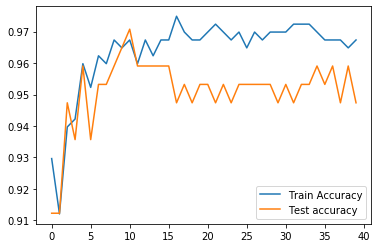

In [6]:
plt.figure()

plt.plot(acc_tree_train, label='Train Accuracy')
plt.plot(acc_tree_test, label='Test accuracy')

plt.legend()

plt.show()

### Exercise 2.3

Analyze the **diversity** among the base learner' outputs for different *nperc* rates. You can analyze this diversity by measuring the correlation among the learner's soft-outputs. Firstly, obtain the matrix with all pairwaise correlation values (over the training learners' outputs) and, then, compute the ensemble diversity as one minus the averaged value of all pairwise correlation values. Finally, analyze the results.

Some useful functions: [np.corrcoef](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html)

Note: You can find other ensemble diversity measurements in https://lucykuncheva.co.uk/papers/lkml.pdf

In [0]:
from statistics import mean

def getDiversity(soft_output):

  correlation_matrix = np.corrcoef(soft_output)
  elements = []

  for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
      if (i>j):
         elements.append(correlation_matrix[i, j])

  avg = mean(elements)
  
  return 1 - avg

In [0]:
nperc_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
train_diversity = []
test_diversity = []
test_accuracy = []

for nperc_value in nperc_values:
  acc_tree_train, acc_tree_test, Y_pred_train, Y_pred_test, soft_output_train, soft_output_test = BaggEnsemble(X_train, Y_train, X_test, Y_test, T = 40, nperc = nperc_value)
    
  train_diversity.append(getDiversity(soft_output_train))
  test_diversity.append(getDiversity(soft_output_test))
  test_accuracy.append(mean(acc_tree_test))
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


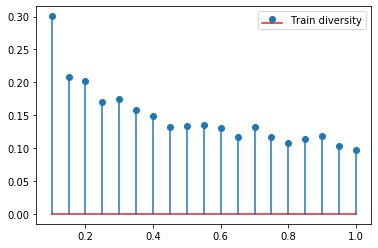

In [9]:
plt.figure()

plt.stem(nperc_values, train_diversity, label='Train diversity')

plt.legend()

plt.show()

As we can see, eventhough the diversity varys something, the test accuracy doesn't among the different n-perc values. Therefore we could deduce that, for our case, the diversity measure is not relevant.

### Exercise 2.4

Compare the performace of the bagged ensemble trained in Exercise 2.1 with that of a Random Forest with the same number of learners, and using trees with a maximum depth of 2. Which differences are between both methods? 

Analyze the feature importances provided by the method RandomForestClassifier().


In [0]:
from sklearn.ensemble import RandomForestClassifier

randomForestCLF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
randomForestCLF.fit(X_train, Y_train) 

acc_tree_train, acc_tree_test, Y_pred_train, Y_pred_test, soft_output_train, soft_output_test = BaggEnsemble(X_train, Y_train, X_test, Y_test, T = 100, nperc = 0.5)

In [11]:
print('Random Forest Test Accuracy', accuracy_score(Y_test, randomForestCLF.predict(X_test)))
print('Trees Test Accuracy', mean(acc_tree_test))

Random Forest Test Accuracy 0.935672514619883
Trees Test Accuracy 0.9344444444444444


### Exercise 3.Boosting methods

### Exercise 3.1

Complete the following cell code to desing a funtion able to train a boosting ensemble of $T$ decision trees. Again, fix the maximum depth of the tree to 2.



In [0]:
from math import log

def calculateAlpha(D, Y_train_predictions, Y_train, tree_id):

  gamma = np.sum((D[tree_id,:] * Y_train_predictions[tree_id,:]*Y_train), axis = 0)

  return (1/2*np.log((1+gamma)/(1-gamma)))

In [0]:
def calculateNextD(D, alpha, Y_train_predictions, Y_train):

  return D*np.exp(-alpha * Y_train_predictions*Y_train)


In [0]:
def RAEnsemble(X_train, Y_train, X_test, Y_test, T):

  Y_train_predictions = np.zeros((T, Y_train.shape[0]))
  Y_test_predictions = np.zeros((T, Y_test.shape[0]))

  f_Train = np.zeros((T,X_train.shape[0]))
  f_Test = np.zeros((T,X_test.shape[0]))

  acc_tree_train = []
  acc_tree_test = []
  alpha = np.zeros(T)

  Dt_all =  np.zeros((T, X_train.shape[0])) 
  Dt_all[0,:] = 1/len(X_train)  

  Y_train=np.where(Y_train>0 ,Y_train,-1)
  Y_test=np.where(Y_test>0 ,Y_test,-1)

  for i in range(T):    

    learner = DecisionTreeClassifier(max_depth=2)

    learner.fit(X_train, Y_train, sample_weight = Dt_all[i])

    Y_train_predictions[i] = learner.predict(X_train)
    Y_test_predictions[i] = learner.predict(X_test)
    
    alpha[i] = calculateAlpha(Dt_all, Y_train_predictions, Y_train, i)

    Dt = calculateNextD(Dt_all[i,:], alpha[i], Y_train_predictions[i,:], Y_train)

    if i!=T-1:
      Dt_all[i+1] = Dt/np.sum(Dt)
    else:
      pass

    f_Train[i]=Y_train_predictions[i,:]*alpha[i]
    f_final=np.sum(f_Train[:i+1], axis=0)
    f_final=np.where(f_final>0.5 ,f_final,-1)
    f_final=np.where(f_final<0.5 ,f_final,1)

    f_Test[i]=Y_test_predictions[i,:]*alpha[i]
    f_final2=np.sum(f_Test[:i+1], axis=0)
    f_final2=np.where(f_final2>0.5 ,f_final2,-1)
    f_final2=np.where(f_final2<0.5 ,f_final2,1)

    acc_tree_train.append(accuracy_score(Y_train, f_final))
    acc_tree_test.append(accuracy_score(Y_test, f_final2))

  return acc_tree_train, acc_tree_test, f_Train, f_Test, alpha, Dt_all

### Exercise 3.2

Train a Real Adaboost ensemble of 40 trees and analyze the accuracy results over train and test data. Discuss the results. 

Remember that RA learners' output have to provide outputs between $[-1,1]$, so convert the data labels to values $-1$ and $1$ to make this work.

In [0]:
acc_tree_train, acc_tree_test, f_Train, f_Test, alpha, Dt_all = RAEnsemble(X_train, Y_train, X_test, Y_test, T=40)

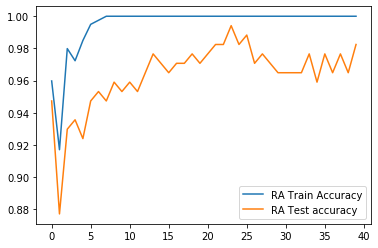

In [16]:
plt.figure()

plt.plot(acc_tree_train, label='RA Train Accuracy')
plt.plot(acc_tree_test, label='RA Test accuracy')

plt.legend()

plt.show()

### Exercise 3.3. 
Finally,  plot the evolution of the emphasis function and the alpha values. Analyze the results.

No handles with labels found to put in legend.


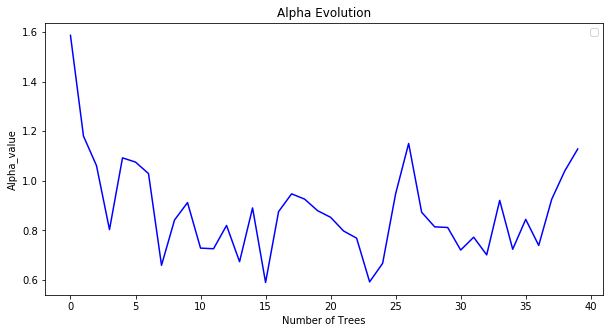

In [17]:
plt.figure(figsize=(10,5))
plt.plot(alpha,'b')
plt.xlabel('Number of Trees')
plt.ylabel('Alpha_value')
plt.title('Alpha Evolution')
plt.legend()
plt.show()

# 5. Bias and variance trade-off

Consider that the real model behind our dasaset is given by:

$$Y = f(X) + \epsilon$$

so an observation $x$ is generated from the r.v.  $X$ and, then, it is transformed by a function $f(\cdot)$ and contaminated by an additive gaussian noise $\epsilon$ of zero mean and variance $\sigma_{\epsilon}^2$, to finally generate the target or label value $y$.

When a classifier or estimator is designed from a set of observations and labels, we design a function $\hat{f}(\cdot)$ trying to approximate as well as possible the original funtion $f(\cdot)$. In this case, **the expected squared prediction error** is:

$$ \mathbb{E} \left[ \left(Y−\hat{f}(X)\right)^2\right] = \mathbb{E} \left[ \left({f}(X) + \epsilon −\hat{f}(X)\right)^2\right] =  \left(\mathbb{E} \left[ {f}(X) \right]−\mathbb{E} \left[\hat{f}(X)\right]\right)^2 + \mathbb{E} \left[ \left(\hat{f}(X) − \mathbb{E}\left[ \hat{f}(X)\right]\right)^2\right] +  \sigma_{\epsilon}^2$$

Thus, this error can be decomposed into:
* A squared **bias** term ($\left(\mathbb{E} \left[ {f}(X) \right]−\mathbb{E} \left[\hat{f}(X)\right]\right)^2$): This terms represents the expected  difference between the prediction of the designed model and the value given by the real model. 
* A **variance** term ($\mathbb{E} \left[ \left(\hat{f}(X) − \mathbb{E}\left[ \hat{f}(X)\right]\right)^2\right]$): This term measures the variability of a model prediction.
* The **noise** term. This is the noise term presenting in the generation data model.

Usually, we have a single dataset and we train a unique model, so talking about expected or average prediction values might sounds quite strange. However, to undertand what these expectations are representing, consider that we can generate different training data sets from the distribution of $X$ and, for each data set, we can create a new model. Due to randomness in the underlying data sets, the resulting models will have a range of predictions. So, the bias term measures how far these models' predictions are from the correct value; whereas, the variance measures these predictions (for a given sample) vary between different realizations of the model.



<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bias_Var.png" width="40%" > 



These  error terms are related to complexity of the model and to the concepts of under-fitting and over-fitting that we reviewed in the previous notebooks:
* Imagine that we have a **complex model**, able to be adjusted to the training data. In this case, different runs of the training data will generate quite different models, presenting a high variability or **high-variance** among them. These models usually present a high risk of **overfitting** and a bad generalizaztion capability.
* Now consider a **simpler model**, that don't tend to overfit, but may **underfit** their training data since it is not able to capture data distribution. Different realizations of this model will present similar predictions, but all of them will be far from the real value to be predicted, presenting a **high bias**.

In an ideal scenario, we would have infinite data to learn our model and we should be able to reduce both the bias and variance terms to 0. However, in a real world, there is a tradeoff between minimizing the bias and minimizing the variance and we can control this with the model complexity. As we increase the model complexity (more parameters are added), we can get to reduce the bias, but the variance is increased.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/ML/Ensembles/Bias_Var_ModelComplexity.png" width="40%" > 





Check the next cell code where the bias and variance term are computed for a decission tree classifier.

Note that, in this example, we are modeling a noise free problem ($\sigma_{\epsilon}^2=0$). That is, we are considering $Y = f(X)$.


The squared Bias term is:  [0.02785167 0.02024253 0.0162116  0.01341125 0.01316749 0.01266784
 0.01243216 0.0122884 ]
The Variance term is:  [0.03253497 0.03339543 0.03457926 0.0354464  0.03581318 0.03587346
 0.03549402 0.03563779]
The MSE is:  [0.06038664 0.05363796 0.05079086 0.04885764 0.04898067 0.0485413
 0.04792619 0.04792619]
We can check that MSE = Bias^2 + Variance


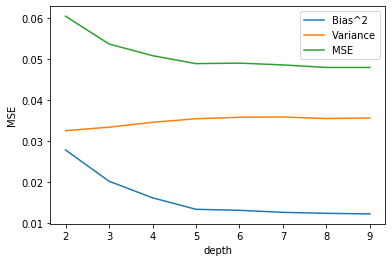

In [18]:
nperc=0.4
niter=100

# Use all data together (we don not nedd test data anymore)
X = np.vstack((X_train,X_test))
Y = np.hstack((Y_train,Y_test))

N = X.shape[0]
Nsub = np.int(nperc*N)

all_f_pred = np.zeros((niter,N))

rang_depth =  np.arange(2,10)

Bias2 = np.zeros((rang_depth.shape[0],N))
Var = np.zeros((rang_depth.shape[0],N))
MSE = np.zeros((rang_depth.shape[0],N))

for d, depth in enumerate(rang_depth):

  clf_tree = tree.DecisionTreeClassifier(max_depth=depth) 
  for i in range(niter):
    # Select some random samples
    samplesid = np.random.choice(N, Nsub, replace=False)
    X_train_sub  = X[samplesid,:]
    Y_train_sub  = Y[samplesid]

    # Train a tree with randomized dataset
    clf_tree.fit(X_train_sub, Y_train_sub)

    # Compute predicted output (overall available data)
    f_pred = clf_tree.predict(X)
    all_f_pred[i,:] = f_pred

  # Mean value of the predicted outputs for each data
  avg_f = np.mean(all_f_pred,axis =0)

  # Obtain the bias^2 of each data
  Bias2[d, :] = (Y - avg_f)**2
  # Obtain the var of each data
  Var[d, :] = np.mean((all_f_pred - avg_f)**2,axis=0)
  # Obtain MSE
  MSE[d,:] = np.mean((Y-all_f_pred)**2,axis=0)


# Print the results averaged over all data
Bias2mean = np.mean(Bias2,axis=1)
Varmean = np.mean(Var,axis=1)
MSEmean = np.mean(MSE,axis=1)

print("The squared Bias term is: ", Bias2mean)
print("The Variance term is: ",Varmean)
print("The MSE is: ",MSEmean)
print("We can check that MSE = Bias^2 + Variance")

plt.figure()
plt.plot(rang_depth, Bias2mean, label='Bias^2')
plt.plot(rang_depth, Varmean, label='Variance')
plt.plot(rang_depth, MSEmean, label='MSE')


plt.legend()
plt.xlabel('depth')
plt.ylabel('MSE')

plt.show()

### Exercise 4. Advanced work: Bias and variance trade off for ensemble methods

Analyze the bias and variance terms evolution with the number of base learners in:
* the bagged ensemble designed in exercise 2.1. 
* the RA ensemble designed in exercise 3.1.

Generate 100 random partitions of training data and you can run the ensemble with only 20 learners. Analyze and discuss the results. 



In [0]:
nperc=0.4
niter=100
T = 20


# Use all data together (we don not nedd test data anymore)
X = np.vstack((X_train,X_test))
Y = np.hstack((Y_train,Y_test))

N = X.shape[0]
Nsub = np.int(nperc*N)

all_f_pred_bagg = []
all_f_pred_RA = []

Bias2_bagg = np.zeros((T,N))
Var_bagg = np.zeros((T,N))
MSE_bagg = np.zeros((T,N))

Bias2_RA = np.zeros((T,N))
Var_RA = np.zeros((T,N))
MSE_RA = np.zeros((T,N))

for i in range(niter):
    # Select some random samples
    samplesid = np.random.choice(N, Nsub, replace=False)
    X_train_sub  = X[samplesid,:]
    Y_train_sub  = Y[samplesid]

    # Train with randomized dataset
    [_,_,Y_pred_tr_bagg, Y_pred_tst_bagg,_,_] = BaggEnsemble(X_train_sub, Y_train_sub, X, Y,T = 20, nperc=0.5)
    [_,_, Y_pred_tr_RA, Y_pred_tst_RA,_,_]=RAEnsemble(X_train_sub, Y_train_sub, X, Y, T=20)

    # Compute predicted output (overall available data)

    all_f_pred_bagg.append(Y_pred_tst_bagg)
    all_f_pred_RA.append(Y_pred_tst_RA)



In [0]:

# Mean value of the predicted outputs for each data
avg_f_bagg = np.mean(all_f_pred_bagg,axis =0)
avg_f_RA = np.mean(all_f_pred_RA,axis =0)

# Obtain the bias^2 of each data
Bias2_bagg= (Y - avg_f_bagg)**2
Bias2_RA = (Y - avg_f_RA)**2
# Obtain the var of each data
Var_bagg = np.mean((all_f_pred_bagg - avg_f_bagg)**2,axis=0)
Var_RA= np.mean((all_f_pred_RA - avg_f_RA)**2,axis=0)
# Obtain MSE
MSE_bagg = np.mean((Y-all_f_pred_bagg)**2,axis=0)
MSE_RA = np.mean((Y-all_f_pred_RA)**2,axis=0)


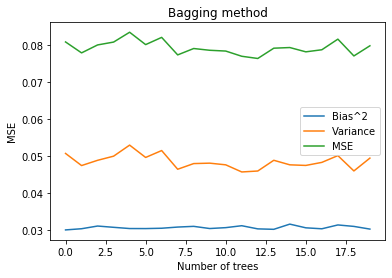

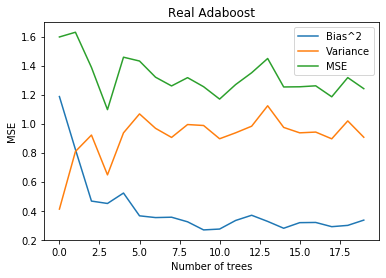

In [23]:
Bias2_bagg_mean = np.mean(Bias2_bagg,axis=1)
Var_bagg_mean = np.mean(Var_bagg,axis=1)
MSE_bagg_mean = np.mean(MSE_bagg,axis=1)

Bias2_RA_mean = np.mean(Bias2_RA,axis=1)
Var_RA_mean = np.mean(Var_RA,axis=1)
MSE_RA_mean = np.mean(MSE_RA,axis=1)

plt.figure()
plt.plot(range(T), Bias2_bagg_mean, label='Bias^2')
plt.plot(range(T), Var_bagg_mean, label='Variance')
plt.plot(range(T), MSE_bagg_mean, label='MSE')


plt.legend()
plt.title('Bagging method')
plt.xlabel('Number of trees')
plt.ylabel('MSE')

plt.figure()
plt.plot(range(T), Bias2_RA_mean, label='Bias^2')
plt.plot(range(T), Var_RA_mean, label='Variance')
plt.plot(range(T), MSE_RA_mean, label='MSE')


plt.legend()
plt.title('Real Adaboost')
plt.xlabel('Number of trees')
plt.ylabel('MSE')

plt.show()

Firstly, the main goal of every model is to have enough degrees of freedom to deal with the underlying complexity of the data we are using, but we also want it to have not too much degrees of freedom to avoid high variance and be more robust. In esembles, the base learner perform not so well because it can has a high bias (low degree of freedom models, for example) or because they have too much variance to be robust (high degree of freedom models, for example). The idea of ensemble methods is to try reducing bias and variance of the weak learners by union or esemble of all of them in order to create a strong learner (ensemble model) and in that way reach better performances.

Finnaly, we conclude that with boosting and bagging methods the learners that alone has bad behavior with respect to bias and variance, when they are ensembled, thanks to the diversity reached between them, is possible to decrease the values of variance and bias of our ensemble and we obtain the desired robust classifier.